In [1]:
# !pip uninstall virny -y

In [2]:
# Install using an HTTP link
# !pip install git+https://github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

# Install using an SSH link
# !pip install git+ssh://git@github.com/DataResponsibly/Virny.git@feature/add_datasets_for_benchmark

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from virny.datasets import DiabetesDataset2019
from virny.utils.model_tuning_utils import tune_ML_models
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.utils.data_viz_utils import create_dataset_stats_bar_chart
from virny.utils.custom_initializers import create_models_config_from_tuned_params_df

from pprint import pprint
from datetime import datetime, timezone
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from EDA_utils import get_correlation_with_target, get_correlation_matrix, get_features_by_target_correlation_threshold

## Load dataset

In [6]:
DATASET_SPLIT_SEED = 100
MODELS_TUNING_SEED = 100
TEST_SET_FRACTION = 0.2
DATASET_NAME = 'Diabetes_2019'

sensitive_attributes_dct = {'Gender': 'Female',  'Age': 'less than 40', 'Gender & Age': None}
sensitive_attributes = [attr for attr in sensitive_attributes_dct.keys() if '&' not in attr]

In [7]:
data_loader = DiabetesDataset2019(with_nulls=False)
data_loader.full_df.head()

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,0
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,0
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,0
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,0
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,0


In [8]:
data_loader.target

'Diabetic'

In [9]:
data_loader.full_df.shape

(905, 18)

In [10]:
data_loader.full_df.isnull().sum()

Age                 0
Gender              0
Family_Diabetes     0
highBP              0
PhysicallyActive    0
BMI                 0
Smoking             0
Alcohol             0
Sleep               0
SoundSleep          0
RegularMedicine     0
JunkFood            0
Stress              0
BPLevel             0
Pregnancies         0
Pdiabetes           0
UriationFreq        0
Diabetic            0
dtype: int64

In [11]:
data_loader.full_df.nunique()

Age                  4
Gender               2
Family_Diabetes      2
highBP               2
PhysicallyActive     4
BMI                 26
Smoking              2
Alcohol              2
Sleep                8
SoundSleep          12
RegularMedicine      3
JunkFood             4
Stress               4
BPLevel              6
Pregnancies          5
Pdiabetes            2
UriationFreq         2
Diabetic             2
dtype: int64

## Check proportions and base rates

In [12]:
create_dataset_stats_bar_chart(data_loader.X_data, data_loader.y_data, sensitive_attributes_dct)

alt.FacetChart(...)

### Data Profiling

In [13]:
for col in data_loader.categorical_columns:
    print(f'{col}: {len(data_loader.full_df[col].unique())}')

Age: 4
Gender: 2
Family_Diabetes: 2
highBP: 2
PhysicallyActive: 4
Smoking: 2
Alcohol: 2
RegularMedicine: 3
JunkFood: 4
Stress: 4
BPLevel: 6
Pdiabetes: 2
UriationFreq: 2


In [14]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
column_transformer = column_transformer.set_output(transform="pandas")  # Set transformer output to a pandas df

In [15]:
full_processed_df = column_transformer.fit_transform(data_loader.full_df)
list(full_processed_df.columns)

['Age_40-49',
 'Age_50-59',
 'Age_60 or older',
 'Age_less than 40',
 'Gender_Female',
 'Gender_Male',
 'Family_Diabetes_no',
 'Family_Diabetes_yes',
 'highBP_no',
 'highBP_yes',
 'PhysicallyActive_less than half an hr',
 'PhysicallyActive_more than half an hr',
 'PhysicallyActive_none',
 'PhysicallyActive_one hr or more',
 'Smoking_no',
 'Smoking_yes',
 'Alcohol_no',
 'Alcohol_yes',
 'RegularMedicine_no',
 'RegularMedicine_o',
 'RegularMedicine_yes',
 'JunkFood_always',
 'JunkFood_occasionally',
 'JunkFood_often',
 'JunkFood_very often',
 'Stress_always',
 'Stress_not at all',
 'Stress_sometimes',
 'Stress_very often',
 'BPLevel_High',
 'BPLevel_Low',
 'BPLevel_high',
 'BPLevel_low',
 'BPLevel_normal',
 'BPLevel_normal ',
 'Pdiabetes_0',
 'Pdiabetes_yes',
 'UriationFreq_not much',
 'UriationFreq_quite often',
 'BMI',
 'Sleep',
 'SoundSleep',
 'Pregnancies',
 'Diabetic']

### Correlation of sensitive attributes with the target

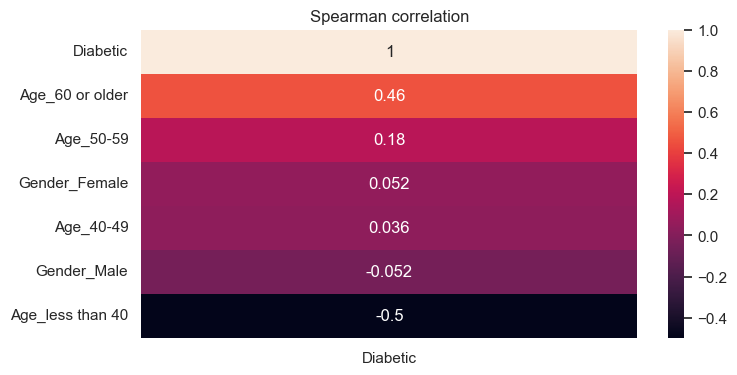

In [16]:
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=[col for col in full_processed_df.columns \
                                           if col != data_loader.target \
                                           and (col.startswith(sensitive_attributes[0]) or col.startswith(sensitive_attributes[1]))
                                           ],
                            heatmap_size=(4, 8))

### Correlation of selected attributes with the target

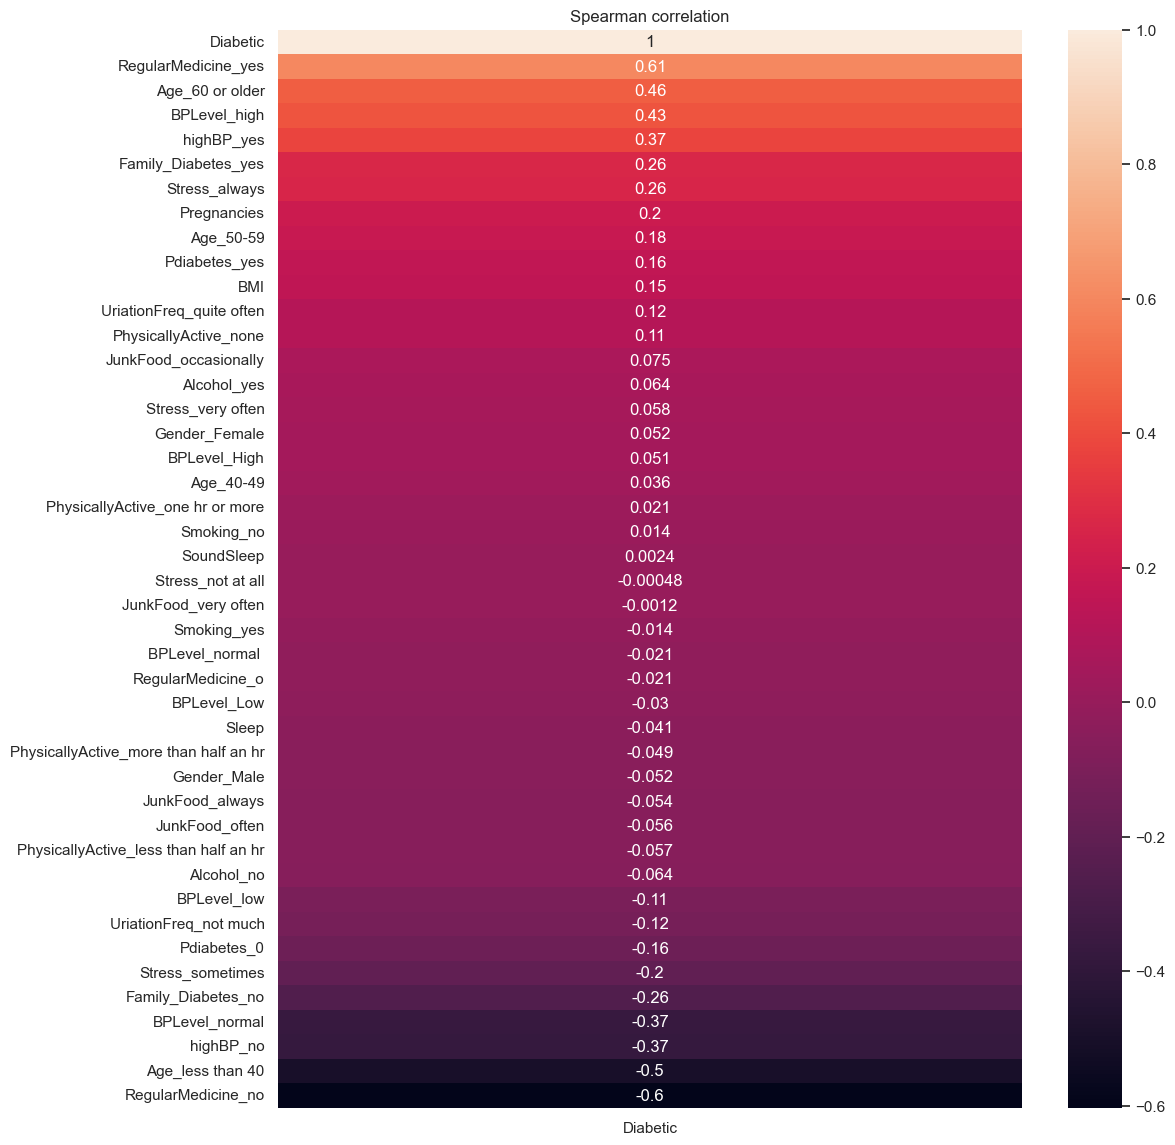

In [17]:
filtered_feature_names = [col for col in full_processed_df.columns 
                          if col != data_loader.target]
get_correlation_with_target(df=full_processed_df,
                            target_name=data_loader.target,
                            feature_names=filtered_feature_names,
                            heatmap_size=(14, 12))

### Correlation matrix for features which have high correlation with the target

In [35]:
high_correlated_features = get_features_by_target_correlation_threshold(
    df=full_processed_df[filtered_feature_names + [data_loader.target]],
    target=data_loader.target,
    threshold=0.2
)
high_correlated_features

['Age_60 or older',
 'Age_less than 40',
 'Family_Diabetes_no',
 'Family_Diabetes_yes',
 'highBP_no',
 'highBP_yes',
 'RegularMedicine_no',
 'RegularMedicine_yes',
 'Stress_always',
 'BPLevel_high',
 'BPLevel_normal',
 'Pregnancies']

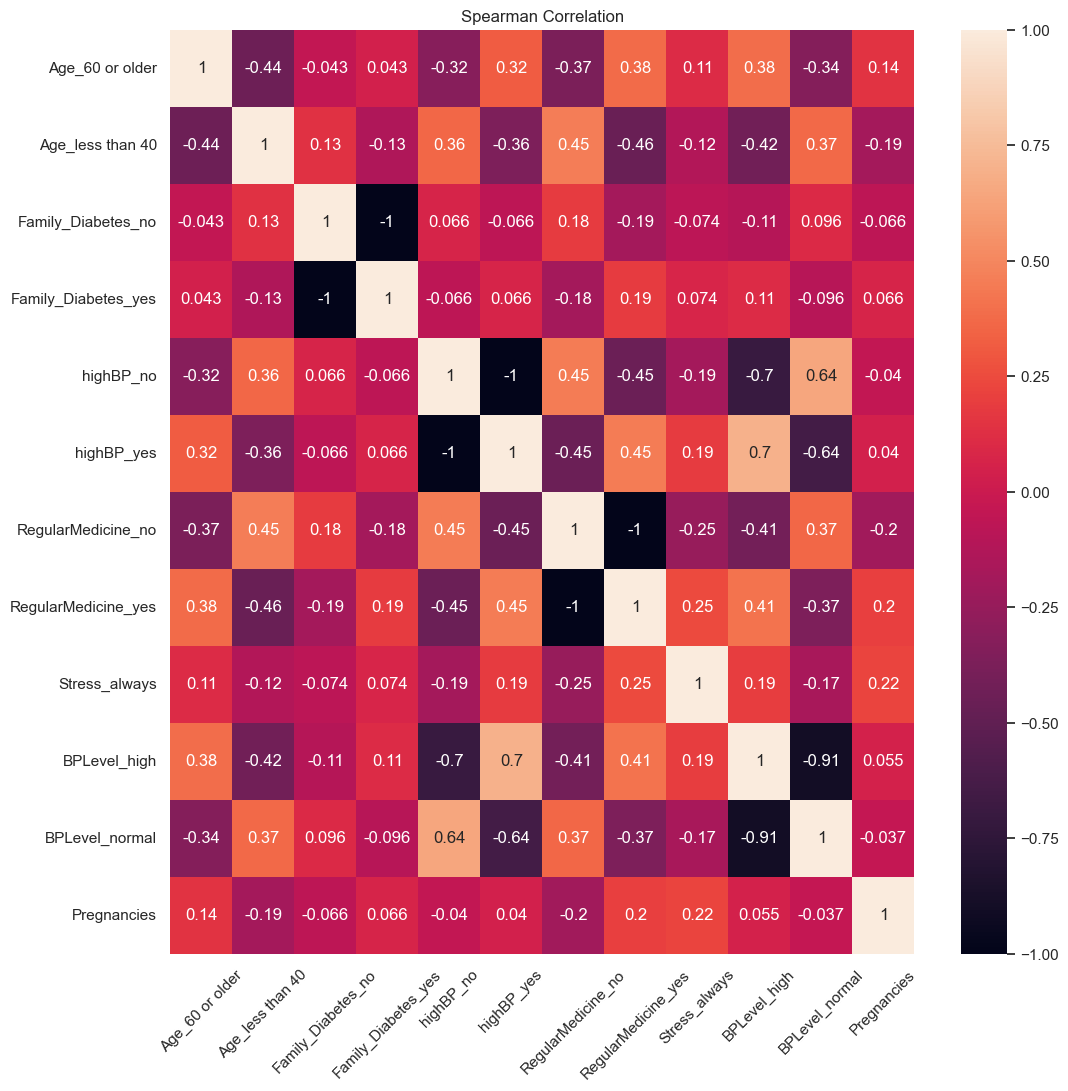

In [37]:
get_correlation_matrix(df=full_processed_df,
                       feature_names=high_correlated_features,
                       heatmap_size=(12, 12))

## Data preparation

In [20]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), data_loader.categorical_columns),
        ('num', StandardScaler(), data_loader.numerical_columns),
    ],
    verbose_feature_names_out=False
)

In [21]:
base_flow_dataset = preprocess_dataset(data_loader=data_loader,
                                       column_transformer=column_transformer,
                                       sensitive_attributes_dct=sensitive_attributes_dct,
                                       test_set_fraction=TEST_SET_FRACTION,
                                       dataset_split_seed=DATASET_SPLIT_SEED)

## Tune RandomForest

In [22]:
models_params_for_tuning = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=MODELS_TUNING_SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
}

In [23]:
# tuned_params_df, models_config = tune_ML_models(models_params_for_tuning, base_flow_dataset, DATASET_NAME, n_folds=3)
# tuned_params_df

In [24]:
# now = datetime.now(timezone.utc)
# date_time_str = now.strftime("%Y%m%d__%H%M%S")
# tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
# tuned_params_df.to_csv(tuned_df_path, sep=",", columns=tuned_params_df.columns, float_format="%.4f", index=False)

## Analyze Feature Importance With Scikit-Learn

In [25]:
tuned_df_path = os.path.join(os.getcwd(), 'models_tuning', f'tuning_results_{DATASET_NAME}.csv')
models_config = create_models_config_from_tuned_params_df(models_params_for_tuning, tuned_df_path)
pprint(models_config)

{'RandomForestClassifier': RandomForestClassifier(max_depth=10, random_state=100)}


In [26]:
rf = models_config['RandomForestClassifier']
rf = rf.fit(base_flow_dataset.X_train_val, base_flow_dataset.y_train_val)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

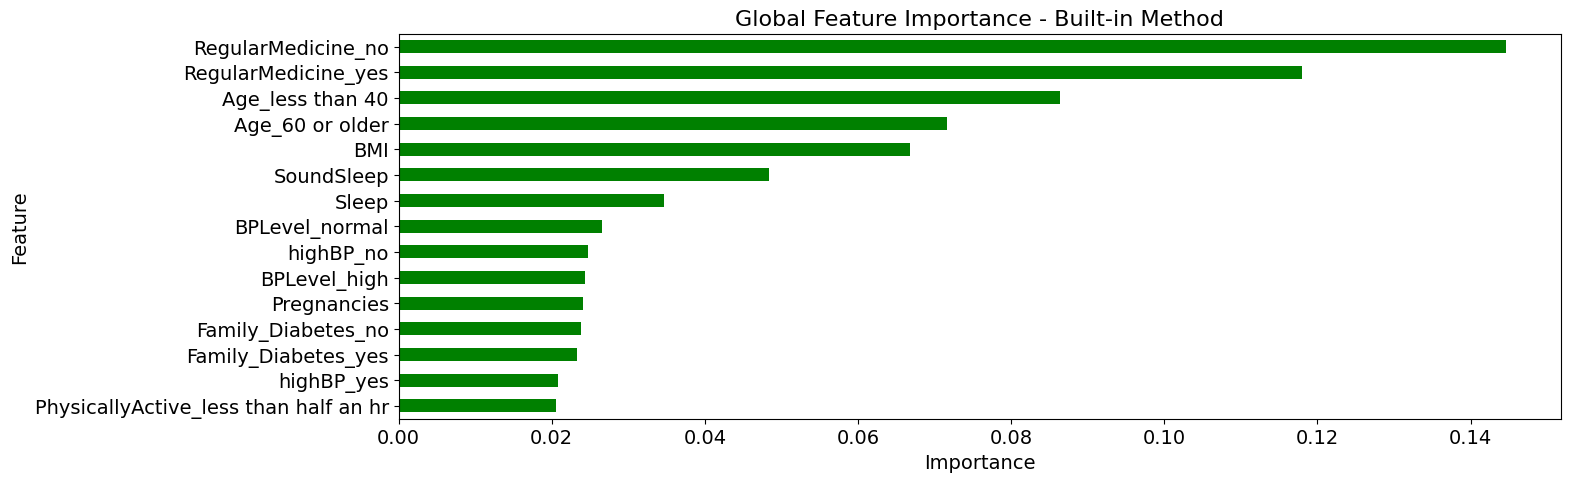

In [27]:
global_importances = pd.Series(rf.feature_importances_, index=base_flow_dataset.X_train_val.columns)
global_importances = global_importances[global_importances > 0.02]
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Global Feature Importance - Built-in Method", fontsize=16)

## Analyze Feature Importance With SHAP

In [28]:
import shap

explainer = shap.Explainer(rf)

In [29]:
shap_values = explainer(base_flow_dataset.X_train_val)

In [30]:
shap_values.shape

(724, 43, 2)

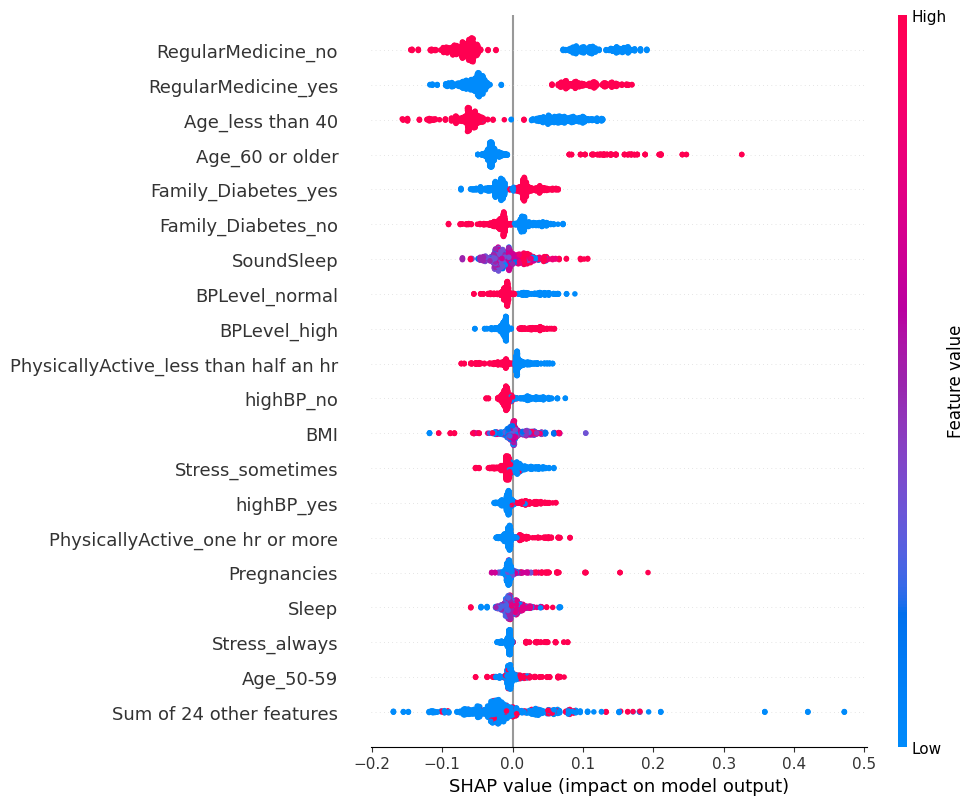

In [31]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

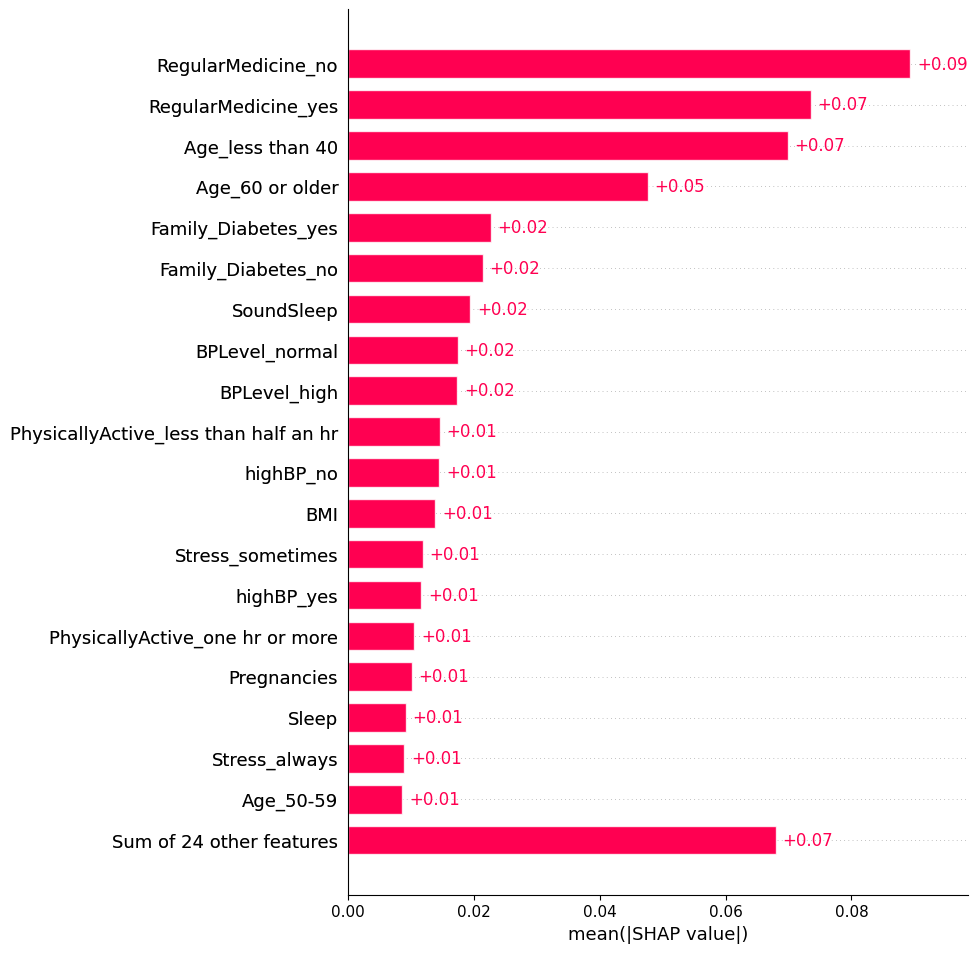

In [32]:
shap.plots.bar(shap_values[:,:,1], max_display=20)